In [2]:
import os,sys
sys.path.append('./../../../../open_AR_Sandbox')
sys.path.append('./../../../../gempy-1.16')
import sandbox.sandbox as sb
import matplotlib.pyplot as plt 
import numpy
import numpy as np
import pandas as pd
import pykinect2
import panel as pn
import matplotlib
pn.extension()
from bokeh.plotting import figure, show, output_file
import cv2 as cv
import cv2
from cv2 import aruco
import scipy.spatial.distance as cdist
import math

ModuleNotFoundError: No module named 'sandbox'

In [2]:
calib = sb.CalibrationData(file = 'my_calibration.json')
sensor = sb.KinectV2(calib)

JSON configuration loaded.
KinectV2 initialized.


In [5]:
marker = sb.ArucoMarkers(sensor)

Mapping between spaces complete


In [6]:
marker.CoordinateMap

,Depth_x,Depth_y,Depth_Z(mm),Color_x,Color_y,Camera_x(m),Camera_y(m),Camera_z(m)
0,214,15,1369,883,-65,-0.156926,0.710718,1.369
1,215,15,1371,886,-65,-0.153446,0.711737,1.371
2,216,15,1368,889,-65,-0.149410,0.710160,1.368
3,217,15,1366,892,-65,-0.145497,0.709103,1.366
4,218,15,1361,895,-65,-0.141283,0.706489,1.361
...,...,...,...,...,...,...,...,...
184145,494,423,1024,1748,1178,0.707317,-0.642680,1.024
184146,496,423,971,1759,1180,0.677712,-0.610639,0.971
184147,497,423,1019,1761,1181,0.714911,-0.641479,1.019
184148,505,423,916,1799,1187,0.669731,-0.581600,0.916


In [ ]:
image = sensor.get_color()
plt.imshow(image)

In [ ]:
image = sensor.get_color()[300:1000,500:1500]
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
aruco_dict = aruco.Dictionary_get(aruco.DICT_4X4_50)
parameters = aruco.DetectorParameters_create()
corners, ids, rejectedImgPoints = aruco.detectMarkers(gray, aruco_dict, parameters=parameters)
image = aruco.drawDetectedMarkers(image, corners, ids)
image = aruco.drawDetectedMarkers(image, rejectedImgPoints, borderColor=(100, 0, 240))
plt.figure(figsize=(20,20))
plt.imshow(image.get())

In [ ]:
aruco_dict = aruco.Dictionary_get(aruco.DICT_4X4_50)
board = aruco.CharucoBoard_create(7, 5, 1, .8, aruco_dict)
imboard = board.draw((2000, 2000))
cv2.imwrite("Chessboard.tiff", imboard)
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.imshow(imboard, cmap = plt.cm.gray, interpolation = "nearest")
ax.axis("off")
plt.show()
fig.savefig("ChharucoChessboard.pdf")

In [ ]:
aruco_dict = aruco.Dictionary_get(aruco.DICT_4X4_50)

fig = plt.figure()
nx = 7
ny = 5
for i in range(1, nx*ny+1):
    ax = fig.add_subplot(ny,nx, i)
    img = aruco.drawMarker(aruco_dict,i-1, 700)
    plt.imshow(img, cmap = plt.cm.gray, interpolation = "nearest")
    ax.axis("off")

plt.savefig("Chessboard.pdf")
plt.show()
#plt.close()

In [ ]:
n=150
images = []

fr = 100
for i in range(n):
    frame = sensor.get_color()
    images.append(frame)

In [ ]:
np.array(images).shape

In [ ]:
plt.imshow(images[60])

In [ ]:
def read_chessboards(images):
    """
    Charuco base pose estimation.
    """
    print("POSE ESTIMATION STARTS:")
    allCorners = []
    allIds = []
    decimator = 0
    # SUB PIXEL CORNER DETECTION CRITERION
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.00001)

    for im in images:
        print("=> Processing image {0}".format(im))
        
        gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
        corners, ids, rejectedImgPoints = cv2.aruco.detectMarkers(gray, aruco_dict)

        if len(corners)>0:
            # SUB PIXEL DETECTION
            for corner in corners:
                cv2.cornerSubPix(gray, corner,
                                 winSize = (3,3),
                                 zeroZone = (-1,-1),
                                 criteria = criteria)
            res2 = cv2.aruco.interpolateCornersCharuco(corners,ids,gray,board)
            if res2[1] is not None and res2[2] is not None and len(res2[1])>3 and decimator%1==0:
                allCorners.append(res2[1])
                allIds.append(res2[2])

        decimator+=1

    imsize = gray.shape
    return allCorners,allIds,imsize

In [ ]:
%%time
allCorners,allIds,imsize=read_chessboards(images)

In [ ]:
def calibrate_camera(allCorners,allIds,imsize):
    """
    Calibrates the camera using the dected corners.
    """
    print("CAMERA CALIBRATION")

    cameraMatrixInit = np.array([[ 1000.,    0., imsize[0]/2.],
                                 [    0., 1000., imsize[1]/2.],
                                 [    0.,    0.,           1.]])

    distCoeffsInit = np.zeros((5,1))
    #flags = (cv2.CALIB_USE_INTRINSIC_GUESS + cv2.CALIB_RATIONAL_MODEL + cv2.CALIB_FIX_ASPECT_RATIO)
    #flags = (cv2.CALIB_RATIONAL_MODEL)
    retval, cameraMatrix, distCoeffs, rvecs, tvecs = cv2.aruco.calibrateCameraAruco(
        corners=allCorners,
        ids=allIds,
        counter = allIds.shape,
        board=board,
        imageSize=imsize,
        cameraMatrix=cameraMatrixInit,
        distCoeffs=distCoeffsInit)
         #flags=flags)
     #stdDeviationsIntrinsics, stdDeviationsExtrinsics,
     #perViewErrors) 
                      #criteria=(cv2.TERM_CRITERIA_EPS & cv2.TERM_CRITERIA_COUNT, 10000, 1e-9))

    return retval, cameraMatrix, distCoeffs, rvecs, tvecs

In [ ]:
retval, cameraMatrix, distCoeffs, rvecs, tvecs = calibrate_camera(allCorners,allIds,imsize)

In [ ]:
cv2.calibrateCamera()

In [ ]:
cv2.TERM_CRITERIA_COUNT

In [ ]:
cv2.TERM_CRITERIA_EPS

In [ ]:
def read_chessboards(images):
    """
    Charuco base pose estimation.
    """
    print("POSE ESTIMATION STARTS:")
    allCorners = []
    allIds = []
    decimator = 0
    aruco_dict = aruco.Dictionary_get(aruco.DICT_4X4_50)
    for im in images:
        print("=> Processing image {0}".format(im))
        #frame = cv2.imread(im)
        gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
        res = cv2.aruco.detectMarkers(gray, aruco_dict)

        if len(res[0])>0:
            res2 = cv2.aruco.interpolateCornersCharuco(res[0],res[1],gray,board)
            if res2[1] is not None and res2[2] is not None and len(res2[1])>3 and decimator%1==0:
                allCorners.append(res2[1])
                allIds.append(res2[2])

        decimator+=1

    imsize = gray.shape
    return allCorners,allIds,imsize
    print("finished")

In [ ]:
%%time
allCorners,allIds,imsize=read_chessboards(images)

In [ ]:
def calibrate_camera(allCorners,allIds,imsize):
    """
    Calibrates the camera using the dected corners.
    """
    print("CAMERA CALIBRATION")

    cameraMatrixInit = np.array([[ 2000.,    0., imsize[0]/2.],
                                 [    0., 2000., imsize[1]/2.],
                                 [    0.,    0.,           1.]])

    distCoeffsInit = np.zeros((5,1))
    flags = (cv2.CALIB_USE_INTRINSIC_GUESS + cv2.CALIB_RATIONAL_MODEL)
    (ret, camera_matrix, distortion_coefficients0,
     rotation_vectors, translation_vectors,
     stdDeviationsIntrinsics, stdDeviationsExtrinsics,
     perViewErrors) = cv2.aruco.calibrateCameraCharucoExtended(
                      charucoCorners=allCorners,
                      charucoIds=allIds,
                      board=board,
                      imageSize=imsize,
                      cameraMatrix=cameraMatrixInit,
                      distCoeffs=distCoeffsInit,
                      flags=flags,
                      criteria=(cv2.TERM_CRITERIA_EPS & cv2.TERM_CRITERIA_COUNT, 10000, 1e-9))

    return ret, camera_matrix, distortion_coefficients0, rotation_vectors, translation_vectors
    print("finished")

In [ ]:
%%time
ret, mtx, dist, rvecs, tvecs = calibrate_camera(allCorners,allIds,imsize)
ret

In [ ]:
%%time
# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*7,3), np.float32)
objp[:,:2] = np.mgrid[0:7,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

#images = glob.glob('calib_images/*.jpg')


for img in images[:4]:
    #img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, (7,6),None)

    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)

        corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
        imgpoints.append(corners2)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (7,6), corners2,ret)


ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)



In [ ]:
cv2.CALIB_USE_INTRINSIC_GUESS

In [ ]:

# Function to draw the axis
def draw(img, corners, imgpts):
    corner = tuple(corners[0].ravel())
    img = cv2.line(img, corner, tuple(imgpts[0].ravel()), (255, 0, 0), 5)
    img = cv2.line(img, corner, tuple(imgpts[1].ravel()), (0, 255, 0), 5)
    img = cv2.line(img, corner, tuple(imgpts[2].ravel()), (0, 0, 255), 5)
    return img

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
objp = np.zeros((6*7,3), np.float32)
objp[:,:2] = np.mgrid[0:7,0:6].T.reshape(-1,2)

axis = np.float32([[3,0,0], [0,3,0], [0,0,-3]]).reshape(-1,3)

for fname in glob.glob('calib_images/left03.jpg'):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (7,6),None)

    if ret == True:
        corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)

        # Find the rotation and translation vectors.
        _,rvecs, tvecs, inliers = cv2.solvePnPRansac(objp, corners2, mtx, dist)
        # project 3D points to image plane
        imgpts, jac = cv2.projectPoints(axis, rvecs, tvecs, mtx, dist)

        img = draw(img,corners2,imgpts)
        cv2.imshow('img',img)
        k = cv2.waitKey(0) & 0xff

In [ ]:
frame = sensor.get_color()
plt.imshow(frame)

In [ ]:
%%time

gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
aruco_dict = aruco.Dictionary_get(aruco.DICT_4X4_50)
parameters =  aruco.DetectorParameters_create()
corners, ids, rejectedImgPoints = aruco.detectMarkers(gray, aruco_dict, parameters=parameters)
frame_markers = aruco.drawDetectedMarkers(frame.copy(), corners, ids)

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(frame_markers)

In [ ]:
mtx = np.array([[  1.46963466e+03,   0.00000000e+00,   2.63094117e+02],
       [  0.00000000e+00,   1.47297770e+03,   3.19127464e+02],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00]])
dist=np.array([[ -4.15557150e+00],
               [  8.04563425e+02],
              [  1.72644822e-01],
              [ -4.62914356e-02],
              [ -1.41439828e+04],
              [  4.99936408e+00],
              [ -2.89968864e+02],
              [  1.96691829e+04],
              [  0.00000000e+00],
              [  0.00000000e+00],
              [  0.00000000e+00],
              [  0.00000000e+00],
              [  0.00000000e+00],
              [  0.00000000e+00]])

In [ ]:
size_of_marker =  0.02 # side lenght of the marker in meter
rvecs,tvecs, trash = aruco.estimatePoseSingleMarkers(corners, size_of_marker , mtx, dist, rvecs, tvecs)

In [ ]:
length_of_axis = 0.1
#imaxis = aruco.drawDetectedMarkers(frame.copy(), corners)
#imaxis = aruco.drawAxis(imaxis, mtx, dist, rvecs, tvecs, length_of_axis)
for i in range(len(tvecs)):
    imaxis = aruco.drawAxis(imaxis, mtx, dist, rvecs[i], tvecs[i], length_of_axis)

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(imaxis)
plt.show()

In [ ]:
rvecs

In [ ]:
dist

In [ ]:
rvecs, tvecs, _objPoints = aruco.estimatePoseSingleMarkers( corners, markerLength, cameraMatrix, distCoeffs[, rvecs[, tvecs[, _objPoints]]] ) 

In [ ]:
cv2.VideoCapture(0)

In [ ]:
aruco_dict = aruco.Dictionary_get(aruco.DICT_4X4_50)
images = []
cv2.namedWindow("Aruco")
vc = cv2.VideoCapture(0)

if vc.isOpened(): # try to get the first frame
    rval, frame = vc.read()
else:
    rval = False

while rval:
    #images.append(frame)
    cv.imshow("Aruco",frame)
    rval, frame = vc.read()
    key = cv2.waitKey(20)
    if key == 27: # exit on ESC
        break
vc.release()
cv2.destroyWindow("Aruco")

In [ ]:
img = np.array(images)[0::10]

In [ ]:
def read_chessboards(images):
    """
    Charuco base pose estimation.
    """
    print("POSE ESTIMATION STARTS:")
    allCorners = []
    allIds = []
    decimator = 0

    for im in images:
        print("=> Processing image {0}".format(im))
        #frame = cv2.imread(im)
        gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
        res = cv2.aruco.detectMarkers(gray, aruco_dict)

        if len(res[0])>0:
            res2 = cv2.aruco.interpolateCornersCharuco(res[0],res[1],gray,board)
            if res2[1] is not None and res2[2] is not None and len(res2[1])>3 and decimator%1==0:
                allCorners.append(res2[1])
                allIds.append(res2[2])

        decimator+=1

    imsize = gray.shape
    return allCorners,allIds,imsize
    print("finished")

In [ ]:
#%%time
allCorners,allIds,imsize=read_chessboards(img)

In [ ]:
def calibrate_camera(allCorners,allIds,imsize):
    """
    Calibrates the camera using the dected corners.
    """
    print("CAMERA CALIBRATION")

    cameraMatrixInit = np.array([[ 2000.,    0., imsize[0]/2.],
                                 [    0., 2000., imsize[1]/2.],
                                 [    0.,    0.,           1.]])

    distCoeffsInit = np.zeros((5,1))
    flags = (cv2.CALIB_USE_INTRINSIC_GUESS + cv2.CALIB_RATIONAL_MODEL)
    (ret, camera_matrix, distortion_coefficients0,
     rotation_vectors, translation_vectors,
     stdDeviationsIntrinsics, stdDeviationsExtrinsics,
     perViewErrors) = cv2.aruco.calibrateCameraCharucoExtended(
                      charucoCorners=allCorners,
                      charucoIds=allIds,
                      board=board,
                      imageSize=imsize,
                      cameraMatrix=cameraMatrixInit,
                      distCoeffs=distCoeffsInit,
                      flags=flags,
                      criteria=(cv2.TERM_CRITERIA_EPS & cv2.TERM_CRITERIA_COUNT, 10000, 1e-9))
    
    print("finished")
    
    return ret, camera_matrix, distortion_coefficients0, rotation_vectors, translation_vectors
    

In [ ]:
%%time
ret, mtx, dist, rvecs, tvecs = calibrate_camera(allCorners,allIds,imsize)

In [ ]:
cameraMatrixInit = np.array([[ 2000.,    0., imsize[0]/2.],
                                 [    0., 2000., imsize[1]/2.],
                                 [    0.,    0.,           1.]])

distCoeffsInit = np.zeros((5,1))
flags = (cv2.CALIB_USE_INTRINSIC_GUESS + cv2.CALIB_RATIONAL_MODEL)
ret, mtx, dist, rvecs, tvecs,stdDeviationsIntrinsics, stdDeviationsExtrinsics, perViewErrors = cv2.aruco.calibrateCameraCharucoExtended(
                  charucoCorners=allCorners,
                  charucoIds=allIds,
                  board=board,
                  imageSize=imsize,
                  cameraMatrix=cameraMatrixInit,
                  distCoeffs=distCoeffsInit,
                  flags=flags,
                  criteria=(cv2.TERM_CRITERIA_EPS & cv2.TERM_CRITERIA_COUNT, 10000, 1e-9))

In [ ]:
#np.savetxt("calib_mtx_webcam.csv", mtx)
#np.savetxt("calib_dist_webcam.csv", dist)
mtx = np.loadtxt("calib_mtx_webcam.csv")
dist = np.loadtxt("calib_dist_webcam.csv")

In [ ]:
mtx.round(0)

In [ ]:
plt.figure(figsize=(20,20))
frame = images[30]
img_undist = cv2.undistort(frame,mtx,dist,None)
plt.subplot(211)
plt.imshow(frame)
plt.title("Corrected image")
plt.axis("off")
plt.subplot(212)
plt.imshow(img_undist)
plt.title("Raw image")
plt.axis("off")
plt.show()

In [ ]:
cv2.namedWindow("Aruco")
vc = cv2.VideoCapture(0)

if vc.isOpened(): # try to get the first frame
    rval, frame = vc.read()
else:
    rval = False

while rval:
    
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    parameters =  aruco.DetectorParameters_create()
    aruco_dict = aruco.Dictionary_get(aruco.DICT_4X4_50)
    corners, ids, rejectedImgPoints = aruco.detectMarkers(gray, aruco_dict, parameters=parameters)
    if ids is not None:
        frame = aruco.drawDetectedMarkers(frame, corners, ids)

        size_of_marker =  0.0145 # side lenght of the marker in meter
        rvecs,tvecs, trash = aruco.estimatePoseSingleMarkers(corners, size_of_marker , mtx, dist)
        length_of_axis = 0.05
        for i in range(len(tvecs)):
            frame = aruco.drawAxis(frame, mtx, dist, rvecs[i], tvecs[i], length_of_axis)
            

    cv.imshow("Aruco",frame)
    rval, frame = vc.read()
    key = cv2.waitKey(20)
    if key == 27: # exit on ESC
        break
vc.release()
cv2.destroyWindow("Aruco")


In [ ]:
vc.release()
cv2.destroyWindow("Aruco")


In [ ]:
rvecs

In [ ]:
fa = np.array([])

In [ ]:
fa= np.append(fa,1)
fa

In [ ]:
images = []

In [ ]:
aruco_dict = aruco.Dictionary_get(aruco.DICT_4X4_50)
cv2.namedWindow("Aruco")
#cv2.namedWindow("Aruco")
frame = sensor.get_color()
rval = True

while rval:
    images.append(frame)
    #gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    #parameters =  aruco.DetectorParameters_create()
    #aruco_dict = aruco.Dictionary_get(aruco.DICT_4X4_50)
    #corners, ids, rejectedImgPoints = aruco.detectMarkers(gray, aruco_dict, parameters=parameters)
    #if ids is not None:
    #    frame = aruco.drawDetectedMarkers(frame, corners, ids)

     #   size_of_marker =  0.0145 # side lenght of the marker in meter
      #  rvecs,tvecs, trash = aruco.estimatePoseSingleMarkers(corners, size_of_marker , mtx, dist)
       # length_of_axis = 0.05
        #for i in range(len(tvecs)):
         #   frame = aruco.drawAxis(frame, mtx, dist, rvecs[i], tvecs[i], length_of_axis)
    
    
    
    cv2.imshow("Aruco",frame)
    frame = sensor.get_color()
    key = cv2.waitKey(20)
    if key == 27: # exit on ESC
        break
cv2.destroyWindow("Aruco")


In [ ]:
aruco_dict = aruco.Dictionary_get(aruco.DICT_4X4_50)

cv2.namedWindow("Aruco")
frame = sensor.get_color()
rval = True

while rval:
    images.append(frame)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    parameters =  aruco.DetectorParameters_create()
    aruco_dict = aruco.Dictionary_get(aruco.DICT_4X4_50)
    corners, ids, rejectedImgPoints = aruco.detectMarkers(gray, aruco_dict, parameters=parameters)
    if ids is not None:
        frame = aruco.drawDetectedMarkers(frame, corners, ids)

        size_of_marker =  0.0145 # side lenght of the marker in meter
        rvecs,tvecs, trash = aruco.estimatePoseSingleMarkers(corners, size_of_marker , mtx, dist)
        length_of_axis = 0.05
        for i in range(len(tvecs)):
            frame = aruco.drawAxis(frame, mtx, dist, rvecs[i], tvecs[i], length_of_axis)
    
    images.append(frame)
    
    cv.imshow("Aruco",frame)
    frame = sensor.get_color()
    key = cv2.waitKey(20)
    if key == 27: # exit on ESC
        break

cv2.destroyWindow("Aruco")

In [ ]:
img_frame = np.array(images)[0::5]
img_frame.shape

In [ ]:
def read_chessboards(images):
    """
    Charuco base pose estimation.
    """
    print("POSE ESTIMATION STARTS:")
    allCorners = []
    allIds = []
    decimator = 0

    for im in images:
        #print("=> Processing image {0}".format(im))
        #frame = cv2.imread(im)
        gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
        res = cv2.aruco.detectMarkers(gray, aruco_dict)
       
        if len(res[0])>0:
            res2 = cv2.aruco.interpolateCornersCharuco(res[0],res[1],gray,board)
            if res2[1] is not None and res2[2] is not None and len(res2[1])>3 and decimator%1==0:
                allCorners.append(res2[1])
                allIds.append(res2[2])

        decimator+=1
    imsize = gray.shape
    print("finished")
    return allCorners,allIds,imsize
    

In [ ]:
%%time
allCorners,allIds,imsize=read_chessboards(img_frame)

In [ ]:
%%time
cameraMatrixInit = np.array([[ 2000.,    0., imsize[0]/2.],
                                 [    0., 2000., imsize[1]/2.],
                                 [    0.,    0.,           1.]])

distCoeffsInit = np.zeros((5,1))
flags = (cv2.CALIB_USE_INTRINSIC_GUESS + cv2.CALIB_RATIONAL_MODEL)
ret, mtx, dist, rvecs, tvecs,stdDeviationsIntrinsics, stdDeviationsExtrinsics, perViewErrors = cv2.aruco.calibrateCameraCharucoExtended(
                  charucoCorners=allCorners,
                  charucoIds=allIds,
                  board=board,
                  imageSize=imsize,
                  cameraMatrix=cameraMatrixInit,
                  distCoeffs=distCoeffsInit,
                  flags=flags,
                  criteria=(cv2.TERM_CRITERIA_EPS & cv2.TERM_CRITERIA_COUNT, 10000, 1e-9))

In [10]:
mtx = np.array([[1.56284319e+03, 0.00000000e+00, 7.88589083e+02],
       [0.00000000e+00, 1.59836898e+03, 8.15536925e+02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])
mtx

array([[1.56284319e+03, 0.00000000e+00, 7.88589083e+02],
       [0.00000000e+00, 1.59836898e+03, 8.15536925e+02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

In [11]:
dist = np.array([[1.59082521e-01],
       [1.24398739e+00],
       [5.03892948e-02],
       [2.14842136e-03],
       [9.16802983e+00],
       [5.99829261e-03],
       [1.25271133e+00],
       [1.09902664e+01],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00]])
dist

array([[1.59082521e-01],
       [1.24398739e+00],
       [5.03892948e-02],
       [2.14842136e-03],
       [9.16802983e+00],
       [5.99829261e-03],
       [1.25271133e+00],
       [1.09902664e+01],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00]])

In [9]:
mtx = marker.mtx
dist = marker.dist

In [13]:
aruco_dict = aruco.Dictionary_get(aruco.DICT_4X4_50)

cv2.namedWindow("Aruco")
frame = sensor.get_color()
#gray = sensor.get_ir_frame()
rval = True

while rval:
    gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    parameters =  aruco.DetectorParameters_create()
    aruco_dict = aruco.Dictionary_get(aruco.DICT_4X4_50)
    corners, ids, rejectedImgPoints = aruco.detectMarkers(gray, aruco_dict, parameters=parameters)
    if ids is not None:
        frame = aruco.drawDetectedMarkers(frame, corners, ids)

        size_of_marker =  0.02# side lenght of the marker in meter
        rvecs,tvecs, trash = aruco.estimatePoseSingleMarkers(corners, size_of_marker , mtx, dist)
        length_of_axis = 0.05
        for i in range(len(tvecs)):
            frame = aruco.drawAxis(frame, mtx, dist, rvecs[i], tvecs[i], length_of_axis)
    
    
    cv.imshow("Aruco",cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))
    frame = sensor.get_color()
    #gray = sensor.get_ir_frame()
    key = cv2.waitKey(20)
    if key == 27: # exit on ESC
        break
cv2.destroyWindow("Aruco")

In [37]:
cv2.destroyWindow("Aruco")

In [45]:
np.shape(corners)

(34, 1, 4, 2)

In [47]:
ids.shape

(34, 1)

In [53]:
np.shape(corners[0][0])

(4, 2)

In [16]:
mtx, dist, rvecs, tvecs = marker.calibrate_camera_charucoBoard()

Start moving randomly the aruco board
Stop moving the board
Calculating Aruco location of  80 images
finished
Calculating camera parameters
Finish


In [17]:
marker.kinect.calib.camera_mtx

[[1977.4905366892494, 0.0, 547.6845435554575],
 [0.0, 2098.757943278828, 962.426967248953],
 [0.0, 0.0, 1.0]]

In [18]:
calib.save_json(file='my_calibration.json')

JSON configuration file saved: my_calibration.json


In [15]:
marker.kinect.calib.camera_mtx

AttributeError: 'CalibrationData' object has no attribute 'camera_mtx'

In [12]:
a = mtx.tolist()

In [14]:
import json
json.dump(a)

TypeError: dump() missing 1 required positional argument: 'fp'

In [24]:
calib.camera_dist

[[-0.1521704243263453],
 [-0.5137710352422746],
 [-0.010673768065933672],
 [0.01065954734833698],
 [2.2812034123550817],
 [0.15820606213404878],
 [0.5618247374672848],
 [-2.195963638734801],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0]]

In [22]:
mtx

array([[1.97749054e+03, 0.00000000e+00, 5.47684544e+02],
       [0.00000000e+00, 2.09875794e+03, 9.62426967e+02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

In [23]:
numpy.array([[1977.4905366892494, 0.0, 547.6845435554575],
 [0.0, 2098.757943278828, 962.426967248953],
 [0.0, 0.0, 1.0]])

array([[1.97749054e+03, 0.00000000e+00, 5.47684544e+02],
       [0.00000000e+00, 2.09875794e+03, 9.62426967e+02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

In [25]:
rvecs

[array([[ 1.86641943],
        [ 2.40863175],
        [-0.44944119]]), array([[ 1.8297652 ],
        [ 2.43178896],
        [-0.43513111]]), array([[ 1.82309644],
        [ 2.43217711],
        [-0.42084544]]), array([[ 1.82370078],
        [ 2.43129001],
        [-0.41357953]]), array([[ 1.95774089],
        [ 2.36854471],
        [-0.40860528]]), array([[ 2.22448987],
        [ 2.29047652],
        [-0.44295855]]), array([[-2.06767698],
        [-1.85258888],
        [ 0.32118216]]), array([[ 2.50408851],
        [ 1.91739038],
        [-0.43519302]]), array([[ 2.64429063],
        [ 1.66980149],
        [-0.33725706]]), array([[ 2.72782599],
        [ 1.38438016],
        [-0.35433143]]), array([[ 2.82513746],
        [ 0.99015313],
        [-0.10078602]]), array([[ 2.61156525],
        [ 1.47265477],
        [-0.19395954]]), array([[ 1.88600068],
        [ 2.24343669],
        [-0.00784101]]), array([[-1.61849016],
        [-2.74715776],
        [ 0.61979973]]), array([[ 1.68536938

In [26]:
ret

0.510415616892727

In [5]:
np.array(calib.camera_mtx)

array([[1.97749054e+03, 0.00000000e+00, 5.47684544e+02],
       [0.00000000e+00, 2.09875794e+03, 9.62426967e+02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

In [4]:
marker.mtx

array([[1.97749054e+03, 0.00000000e+00, 5.47684544e+02],
       [0.00000000e+00, 2.09875794e+03, 9.62426967e+02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

In [7]:
marker.real_time_poseEstimation()

In [7]:
df =marker.find_markers_rgb(1)
df

,ids,Corners_RGB_x,Rotation_vector,Translation_vector,Corners_RGB_y
0,15,931,"[[[-2.090419032757773, 1.76759785085095, 0.784...","[[[0.35582385336429057, -0.34731870746715165, ...",564


In [15]:
corners, ids, rejectedImgPoints = marker.aruco_detect(sensor.get_color())
rvec, tvec, trash = aruco.estimatePoseSingleMarkers([corners[0][0]], marker.size_of_marker, marker.mtx, marker.dist)

In [19]:
df.Corners_RGB_y.values


array([563], dtype=object)

In [9]:
df.Rotation_vector.values[0].shape

(1, 1, 3)

In [15]:
cv2.destroyAllWindows()

In [35]:
df.Rotation_vector.values[0]

array([[[-2.64977749,  2.11638556,  0.10716999]]])

In [40]:
oro

<UMat 00000241E24C2A50>

In [82]:
aruco_dict = aruco.Dictionary_get(aruco.DICT_4X4_50)

cv2.namedWindow("Aruco")
frame = sensor.get_color()

#gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
#parameters =  aruco.DetectorParameters_create()
#aruco_dict = aruco.Dictionary_get(aruco.DICT_4X4_50)
#corners, ids, rejectedImgPoints = aruco.detectMarkers(gray, aruco_dict, parameters=parameters)
#df = marker.find_markers_rgb(1)
#rvecs,tvecs, trash = aruco.estimatePoseSingleMarkers(corners, size_of_marker , mtx, dist)

#for i in range(len(tvecs)):
frame = aruco.drawAxis(frame, 
                           marker.mtx, 
                           marker.dist, 
                           df.Rotation_vector.values[0], 
                           df.Translation_vector.values[0], 
                           length_of_axis)

cv.imshow("Aruco",cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))
#frame = sensor.get_color()
#gray = sensor.get_ir_frame()
key = cv2.waitKey(0)
#if (key == 27): # exit on ESC
#    break
cv2.destroyWindow("Aruco")

In [72]:
len(rvecs)

1

In [71]:
df.Rotation_vector.values[0]

array([[[-2.09041903,  1.76759785,  0.7849292 ]]])

In [83]:
calib.aruco_corners

'{"Corners_RGB_x":{"0":1447,"1":647,"2":1415,"3":651},"ids":{"0":15,"1":5,"2":1,"3":2},"Corners_RGB_y":{"0":951,"1":336,"2":317,"3":965}}'

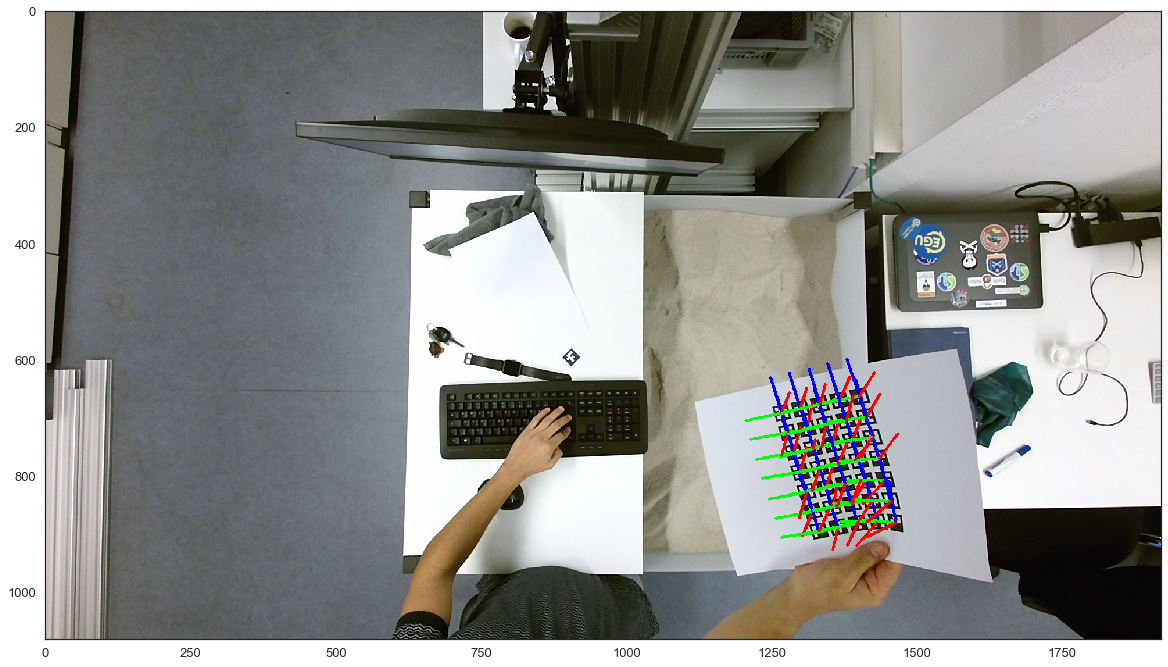

In [10]:
frame = sensor.get_color()
df = marker.find_markers_rgb(1)
frame = marker.drawPoseEstimation(df, frame)
plt.figure(figsize=(20,20))
plt.imshow(frame)


In [11]:
df

,Corners_RGB_y,Corners_RGB_x,Translation_vector,ids,Rotation_vector
0,887,1364,"[[[0.5821821446939538, -0.047658330237424745, ...",7,"[[[-1.6879113034944588, 2.474624030698518, 1.2..."
1,881,1398,"[[[0.6067152178554391, -0.05165396596012391, 1...",14,"[[[1.5485075071014283, -2.2036461291028027, -1..."
2,878,1432,"[[[0.6035204621517287, -0.05113737558251549, 1...",21,"[[[1.5111373984728167, -1.9443857621385914, -1..."
3,860,1320,"[[[0.5419570097863385, -0.06543478857909756, 1...",1,"[[[1.5321309383134598, -2.2675742759036566, -1..."
4,853,1353,"[[[0.5847298178427737, -0.07180160772814702, 1...",8,"[[[1.7222979085974635, -1.9864918599767771, 0...."
5,842,1421,"[[[0.6076474385111729, -0.07551996270163257, 1...",22,"[[[-1.7355269305207324, 2.34647941589037, 1.61..."
6,820,1342,"[[[0.571354427715212, -0.0941418431388298, 1.3...",9,"[[[1.75918594064525, -2.019186286761226, 0.305..."
7,807,1410,"[[[0.6006924311730009, -0.09873060864210191, 1...",23,"[[[1.5095734836957588, -2.1443775611948444, -1..."
8,805,1445,"[[[0.6135500771428142, -0.09800079854660729, 1...",30,"[[[1.4600784540840597, -1.9332943835238185, -1..."
9,773,1400,"[[[0.5904798913976338, -0.1211710120994356, 1....",24,"[[[-2.3223278930070705, 2.602769006140424, -0...."
